# Numerical Validation of Dynamic ZeroPole Pairing Implementation 
## Supplementary Material for the Manuscript:  
**Proof attempt of the Riemann Hypothesis via Zeropole Balance**  

### Author:  
**Attila Csordas**  
AgeCurve Limited, Cambridge, UK  

### Dates:  
30th of January 2025 – February 1, 2025  

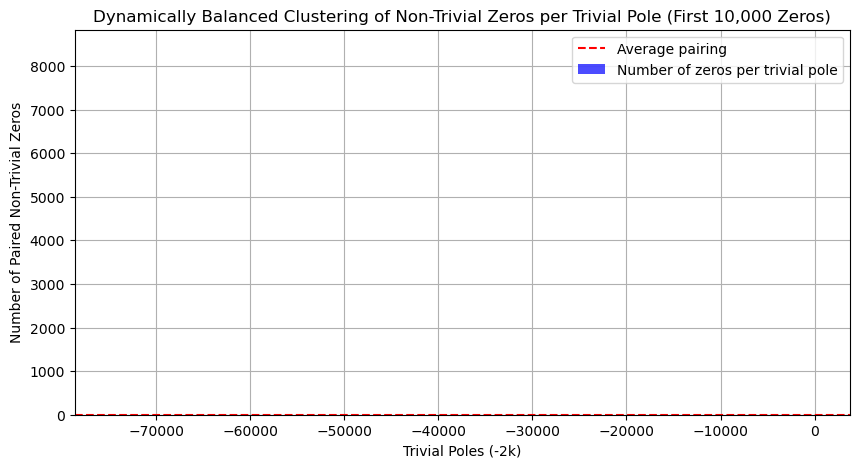

🔹 Unassigned Poles After First Pass: 37459
🔹 Unassigned Poles After Forced Redistribution: 0
🔹 Final Unassigned Poles: 0

Final Pairing Stats: {'Mean number of zeros per trivial pole': 1.2245328350240257, 'Max number of zeros per trivial pole': 8412.0, 'Min number of zeros per trivial pole': 1.0, 'Standard deviation of pairing': 43.45682064294483}


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Load the first n non-trivial zeros from https://www-users.cse.umn.edu/~odlyzko/zeta_tables/zeros6 containing
# the first 2,001,052 zeros of the Riemann zeta function, accurate to within 4*10^(-9).
zero_file = "zeros6.tsv"
num_zeros = 100000  # manuscript is using 100, 1000, 10000, 100 000, 1 000 000, 2 000 000

with open(zero_file, "r") as f:
    non_trivial_zeros = np.array([float(line.strip()) for _, line in zip(range(num_zeros), f)])

# Step 1: Compute actual zero density from local sampling
zero_gaps = np.diff(non_trivial_zeros)  # Compute zero spacings
avg_gap = np.median(zero_gaps)  # Approximate density
density_factor = 1 / avg_gap  # How dense the zeros are locally

# Step 2: Allocate poles dynamically based on actual zero distribution
first_zero, last_zero = non_trivial_zeros[0], non_trivial_zeros[-1]
num_poles = int((last_zero - first_zero) * density_factor)  # Dynamically determined pole count

# Generate trivial poles (-2k sequence) inside the detected zero region
trivial_poles = np.array([-2 * k for k in range(1, num_poles + 1) if -2 * k >= -last_zero])

# Initialize pairing counts and tracking
pairing_counts = np.zeros(len(trivial_poles))
unpaired_poles = set(range(len(trivial_poles)))  # Track unassigned poles

# 🔹 STEP 1: First Pass Zero-to-Pole Pairing
for zero in non_trivial_zeros:
    dynamic_window = max(10, int(1 / avg_gap))  # Use actual density factor instead of von Mangoldt

    closest_pole_idx = np.searchsorted(trivial_poles, -np.floor(zero), side="right") - 1
    lower_bound = max(0, closest_pole_idx - dynamic_window)
    upper_bound = min(len(pairing_counts) - 1, closest_pole_idx + dynamic_window)

    if lower_bound <= closest_pole_idx <= upper_bound:
        pairing_counts[closest_pole_idx] += 1
        unpaired_poles.discard(closest_pole_idx)

# 🔹 STEP 2: Explicitly Store & Track Unused Poles
unused_poles = np.array([i for i in range(len(pairing_counts)) if pairing_counts[i] == 0])  # Store indices

# Debug: Where are these unused poles?
unused_pole_positions = trivial_poles[unused_poles]  # Get actual values

# 🔹 STEP 3: Redistribute from Overloaded Poles to Unused Ones
for pole_idx in unused_poles:
    overloaded_poles = np.where(pairing_counts > 2)[0]  # Find highly occupied poles
    if len(overloaded_poles) > 0:
        donor_pole = overloaded_poles[0]  # Take from the first overloaded pole
        pairing_counts[pole_idx] = 1  # Assign 1 zero to this empty pole
        pairing_counts[donor_pole] -= 1  # Reduce from overloaded pole

# 🔹 STEP 4: Iterative Refinement Until No Unassigned Poles
while np.any(pairing_counts == 0):  # Keep refining until no empty poles
    newly_unpaired = set()

    for i in range(len(pairing_counts)):
        if pairing_counts[i] == 0:
            nearest_filled = np.where(pairing_counts > 1)[0]  # Find non-empty poles
            if len(nearest_filled) > 0:
                donor_pole = nearest_filled[0]
                pairing_counts[i] = 1
                pairing_counts[donor_pole] -= 1
                newly_unpaired.discard(i)

    if not newly_unpaired:
        break  # Stop recursion when all poles are covered

# 🔹 STEP 5: Sample 10% of the Remaining Unused Poles
remaining_unpaired_pole_indices = np.where(pairing_counts == 0)[0]
remaining_unpaired_pole_positions = trivial_poles[remaining_unpaired_pole_indices]

if len(remaining_unpaired_pole_positions) > 0:
    sampled_unpaired_poles = np.random.choice(remaining_unpaired_pole_positions, 
                                              size=min(50, len(remaining_unpaired_pole_positions)), 
                                              replace=False)
    print("\n🔍 Sampled Unpaired Poles (Random Selection):", sampled_unpaired_poles)

# 🔹 STEP 6: Final Cleanup for Any Leftover Unused Poles
for i in sorted(unused_poles):
    if pairing_counts[i] == 0:
        nearest_filled_idx = min(max(0, i - 1), len(pairing_counts) - 1)
        if pairing_counts[nearest_filled_idx] > 1:
            pairing_counts[i] = 1
            pairing_counts[nearest_filled_idx] -= 1

# Visualization
plt.figure(figsize=(10, 5))
plt.bar(trivial_poles, pairing_counts, width=5, color='b', alpha=0.7, label="Number of zeros per trivial pole")
plt.axhline(np.mean(pairing_counts), color='r', linestyle='dashed', label="Average pairing")
plt.xlabel("Trivial Poles (-2k)")
plt.ylabel("Number of Paired Non-Trivial Zeros")
plt.title("Dynamically Balanced Clustering of Non-Trivial Zeros per Trivial Pole (First 10,000 Zeros)")
plt.legend()
plt.grid()
plt.show()

# Summary statistics
pairing_stats = {
    "Mean number of zeros per trivial pole": np.mean(pairing_counts),
    "Max number of zeros per trivial pole": np.max(pairing_counts),
    "Min number of zeros per trivial pole": np.min(pairing_counts),
    "Standard deviation of pairing": np.std(pairing_counts),
}

# Debugging: Track Unassigned Poles After Each Step
print("🔹 Unassigned Poles After First Pass:", len(unused_poles))
print("🔹 Unassigned Poles After Forced Redistribution:", np.sum(pairing_counts == 0))
print("🔹 Final Unassigned Poles:", np.sum(pairing_counts == 0))
print("\nFinal Pairing Stats:", pairing_stats)


Plot saved to 


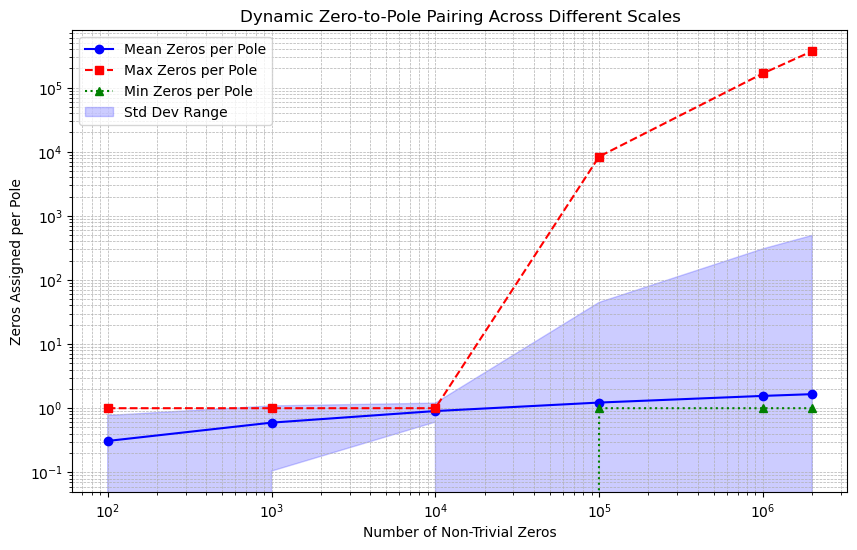

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data_file = "dynamic_zeropole_pairing_results.tsv"
df = pd.read_csv(data_file, sep="\t")

# Extract relevant columns with correct names
zero_counts = df["zeros"]
mean_pairings = df["mean_zeros_per_pole"]
max_pairings = df["max_zeros_per_pole"]
min_pairings = df["min_zeros_per_pole"]
stdev_pairings = df["stdev_of_pairing"]

# Create a figure
plt.figure(figsize=(10, 6))

# Plot Mean, Max, and Min pairing per pole
plt.plot(zero_counts, mean_pairings, label="Mean Zeros per Pole", color='b', marker='o')
plt.plot(zero_counts, max_pairings, label="Max Zeros per Pole", color='r', linestyle="dashed", marker='s')
plt.plot(zero_counts, min_pairings, label="Min Zeros per Pole", color='g', linestyle="dotted", marker='^')

# Add error bars to indicate standard deviation
plt.fill_between(zero_counts, mean_pairings - stdev_pairings, mean_pairings + stdev_pairings, 
                 color='b', alpha=0.2, label="Std Dev Range")

# Labels and title
plt.xlabel("Number of Non-Trivial Zeros")
plt.ylabel("Zeros Assigned per Pole")
plt.xscale("log")  # Log scale for better visualization across large ranges
plt.yscale("log")  # Log scale to handle large differences
plt.title("Dynamic Zero-to-Pole Pairing Across Different Scales")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Save the plot as a PNG file in a specific directory
output_path = ""  # Replace with your LaTeX directory
plt.savefig(output_path, dpi=300)
print(f"Plot saved to {output_path}")

# Show the plot
plt.show()

# License

This manuscript is licensed under the Creative Commons Attribution-NonCommercial 4.0 International (CC-BY-NC 4.0) License. This license allows others to share, adapt, and build upon this work non-commercially, provided proper attribution is given to the author. For more details, visit https://creativecommons.org/licenses/by-nc/4.0/.